In [1]:
import torch as torch

In [2]:
if torch.cuda.is_available():
    cuda_id = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(cuda_id)
    device = "cuda:0"
else:
    device = "cpu"

### Download and preparethe data

We'll use the CIFAR10 dataset

In [3]:
import os
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [4]:
batch_size = 100

In [5]:
# download and augment the training dataset
if not os.path.exists("./data"):
    os.mkdir("./data")

data = CIFAR10(
    root="./data",
    train=True,
    transform=transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=32, ratio=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize(0, 1),
        ]
    ),
    download=True,
)

data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

test_data = CIFAR10(
    root="./data",
    train=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(0, 1),
        ]
    ),
    download=True,
)
test_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
classes = data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Print out an example image

In [7]:
import matplotlib.pyplot as plt

In [8]:
def display(image, size=8):
    print(image[0].shape)
    image = image[0].permute((1, 2, 0))
    plt.figure(figsize=(size, size))
    plt.axis("off")
    plt.imshow(image)
    plt.show()

torch.Size([3, 32, 32])


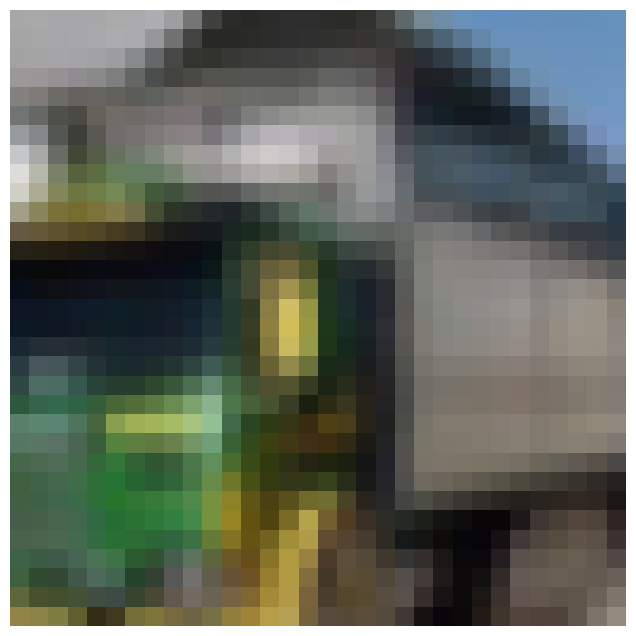

In [9]:
display(data[14])

### Split a batch of data into batch of patches

In [10]:
import torchvision.utils as vutils

In [11]:
def batch_patch(tensor, step=4):
    if len(tensor.shape) == 3:
        return (
            tensor.unfold(0, 3, 3)
            .unfold(1, step, step)
            .unfold(2, step, step)
            .flatten(start_dim=0, end_dim=2)
        )
    return (
        tensor.unfold(1, 3, 3)
        .unfold(2, step, step)
        .unfold(3, step, step)
        .squeeze()
        .flatten(start_dim=1, end_dim=2)
    )

torch.Size([100, 3, 32, 32])


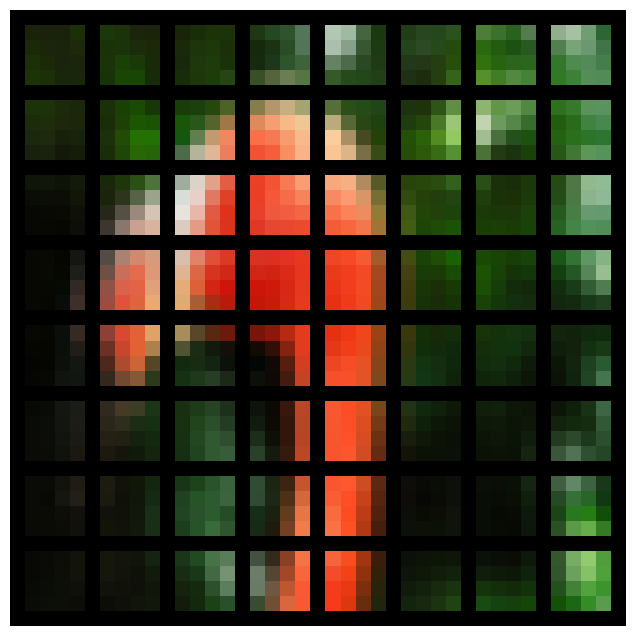

In [12]:
d = next(iter(data_loader))[0]
print(d.shape)

step = 4
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(
    (
        vutils.make_grid(
            batch_patch(d, step)[0], nrow=32 // step, padding=1, normalize=True
        )
        .permute(1, 2, 0)
        .detach()
        .cpu()
        .numpy()
    )
)

### Implement the model

In [13]:
import torch.nn as nn

First implement the learnable positional encoding layer - it was used in DDPM lab

In [14]:
# class PositionalEncoding(nn.Module):
#     def __init__(self, input_size=65, d=25, n=10000, output_size=256):
#         super(PositionalEncoding, self).__init__()
#         denominator = torch.pow(n, torch.arange(d) / d)
#         numerator = torch.arange(input_size).reshape(-1, 1)
#         self.inputs = torch.concat(
#             [torch.sin(numerator / denominator), torch.cos(numerator / denominator)], 1
#         ).to(device)
#         self.network = nn.Sequential(
#             nn.Linear(2 * d, out_features=output_size),
#             nn.ReLU(inplace=True),
#             nn.Linear(in_features=output_size, out_features=output_size),
#         )
# 
#     def forward(self, k):
#         return self.network(self.inputs[k])

Implement a transformer block - We'll need a few of them so it's easier to make a separate class

In [15]:
class TransformerBlock(nn.Module):
    def __init__(self, n_dims=256, n_heads=8):
        super(TransformerBlock, self).__init__()
        self.norm = nn.LayerNorm(n_dims)
        self.attention = nn.MultiheadAttention(n_dims, n_heads)
        self.network = nn.Sequential(
            nn.LayerNorm(n_dims),
            nn.Linear(n_dims, 2 * n_dims),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(2 * n_dims, n_dims),
            nn.Dropout(0.2),
        )

    def forward(self, tr_input):
        residual = tr_input
        out = self.norm(tr_input)
        out = self.attention(out, out, out)[0] 
        out += residual
        residual2 = out
        out = self.network(out)
        out += residual2
        return out

Whole model

In [16]:
class VisionTransformerModel(nn.Module):
    def __init__(self, n_classes, patch_size=4, im_size=32, n_dims=256):
        super(VisionTransformerModel, self).__init__()
        self.patch_size = patch_size
        self.token = torch.rand(n_dims, dtype=torch.float32,requires_grad=True,device=device)
        self.positional_vector = torch.rand(((im_size // patch_size) ** 2 + 1, n_dims),requires_grad=True,device=device)
        self.patch_flatten = nn.Flatten(start_dim=-3)
        self.embed = nn.Linear(3 * patch_size**2, n_dims)
        self.dropout1 = nn.Dropout(0.2)
        self.transformers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=n_dims,
                nhead=8,
                dim_feedforward=2*n_dims,
                dropout=0.2,
                activation="gelu",
                norm_first=True,
                batch_first=True
            ),
            6
        )
        # self.transformers = nn.Sequential(
        #     TransformerBlock(n_dims=n_dims),
        #     TransformerBlock(n_dims=n_dims),
        #     TransformerBlock(n_dims=n_dims),
        #     TransformerBlock(n_dims=n_dims),
        #     TransformerBlock(n_dims=n_dims),
        #     TransformerBlock(n_dims=n_dims),
        # ).to(device)
        self.normalization = nn.LayerNorm(n_dims)
        self.MLP = nn.Linear(n_dims, n_classes)

    def forward(self, img):
        patched = batch_patch(img, self.patch_size)
        
        flattened = self.patch_flatten(patched)
        embedded = self.embed(flattened)

        class_token = torch.ones(img.shape[0]).to(device).reshape(-1, 1, 1) * self.token
        with_token = torch.concat([class_token, embedded], 1)

        with_encode = with_token + self.positional_vector
        
        
        after_dropout = self.dropout1(with_encode)
        tr = self.transformers(after_dropout)[:, 0]
        normalized = self.normalization(tr)
        post_mlp = self.MLP(normalized)
        return post_mlp

### Prepare the model for training

In [17]:
model = VisionTransformerModel(len(data.classes)).to(device)

C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [18]:
from torchviz import make_dot
import torch
from torch.autograd import Variable
x = Variable(torch.rand((100,3,32,32)).to(device), requires_grad=True)
y = model(x)

make_dot(y).render("attached", format="png")

'attached.png'

In [19]:
params = [p for p in model.parameters()] + [model.token, model.positional_vector]
optimizer = torch.optim.AdamW(params, lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [x for x in range(10,16+10,10)], 0.8)
loss_fn = torch.nn.CrossEntropyLoss()

In [20]:
for epoch in range(160):
    iteration = 0
    total_loss = 0
    print("epoch:", epoch)
    for batch in data_loader:
        iteration = 0
        total_loss = 0
        batch_data = batch[0].to(device)
        batch_labels = batch[1].to(device)

        optimizer.zero_grad()
        pred = model(batch_data)
        loss = loss_fn(pred, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss
        iteration += 1

    scheduler.step()
    print(" - loss:", total_loss.item() / iteration)

epoch: 0
 - loss: 1.9523060321807861
epoch: 1
 - loss: 1.913263201713562
epoch: 2
 - loss: 1.9297338724136353
epoch: 3
 - loss: 1.7933152914047241
epoch: 4
 - loss: 1.8075439929962158
epoch: 5
 - loss: 1.8064557313919067
epoch: 6
 - loss: 1.7919929027557373
epoch: 7
 - loss: 1.7563289403915405
epoch: 8
 - loss: 1.7551106214523315
epoch: 9
 - loss: 1.7133078575134277
epoch: 10
 - loss: 1.5076807737350464
epoch: 11
 - loss: 1.9000611305236816
epoch: 12
 - loss: 1.6343863010406494
epoch: 13
 - loss: 1.6621135473251343
epoch: 14
 - loss: 1.629478096961975
epoch: 15
 - loss: 1.6737557649612427
epoch: 16
 - loss: 1.5422215461730957
epoch: 17
 - loss: 1.673427700996399
epoch: 18
 - loss: 1.7649115324020386
epoch: 19
 - loss: 1.512068748474121
epoch: 20
 - loss: 1.7145206928253174
epoch: 21
 - loss: 1.5859516859054565
epoch: 22
 - loss: 1.6530598402023315
epoch: 23
 - loss: 1.6084794998168945
epoch: 24
 - loss: 1.5878039598464966
epoch: 25
 - loss: 1.5700575113296509
epoch: 26
 - loss: 1.60308

In [24]:
model.eval()

VisionTransformerModel(
  (patch_flatten): Flatten(start_dim=-3, end_dim=-1)
  (embed): Linear(in_features=48, out_features=256, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (transformers): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (normalization): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (MLP): Linear(in_features=256, 

In [25]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(100 * correct / total, "%")

70.694 %


truck frog automobile cat truck bird bird ship horse airplane deer ship airplane airplane frog dog 

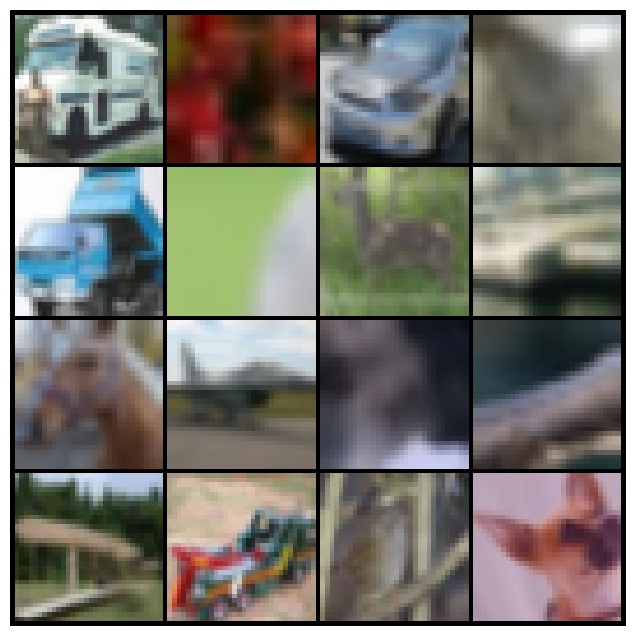

In [26]:
d = next(iter(test_loader))[0][:16].to(device)

classification = torch.argmax(model(d), 1)

for c in classification:
    print(classes[c],end = " ")

step = 4
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(
    (
        vutils.make_grid(d, nrow=4, padding=1, normalize=True)
        .permute(1, 2, 0)
        .detach()
        .cpu()
        .numpy()
    )
)